In [2]:
import os
import json
import sys
from pathlib import Path
sys.path.append(Path(os.getcwd()).parent.as_posix())

import numpy as np
import monai.transforms as mt

import seaborn as sns
import matplotlib.pyplot as plt

from utils import RANDOM_SEED
from dataset import get_dataset

import warnings
warnings.simplefilter("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cwd_path = Path(os.getcwd())
data_path = cwd_path / "data" / "preprocessed_data"
json_path = data_path / "patients_registered.json"

In [4]:
with open(json_path, "r") as f:
    patients_dict = json.load(f)

In [5]:
# class CropAroundMaskd(mt.MapTransform):
#     """
#     Crop a region around the non-zero area of a mask with a specified margin.
#     """

#     def __init__(self, keys, mask_key, margin=10):
#         super().__init__(keys)
#         self.mask_key = mask_key
#         self.margin = margin

#     def __call__(self, data):
#         d = dict(data)
#         mask = d[self.mask_key][0]  # assuming mask shape (C=1, H, W, D)
#         # Find bounding box of non-zero voxels
#         nonzero = np.nonzero(mask)
#         minz, maxz = nonzero[0].min(), nonzero[0].max()
#         miny, maxy = nonzero[1].min(), nonzero[1].max()
#         minx, maxx = nonzero[2].min(), nonzero[2].max()

#         # Expand bounding box by margin, ensuring within image bounds
#         shape = mask.shape
#         minz = max(minz - self.margin, 0)
#         maxz = min(maxz + self.margin + 1, shape[0])
#         miny = max(miny - self.margin, 0)
#         maxy = min(maxy + self.margin + 1, shape[1])
#         minx = max(minx - self.margin, 0)
#         maxx = min(maxx + self.margin + 1, shape[2])

#         # Crop all keys accordingly
#         for key in self.keys:
#             img = d[key]
#             # img shape assumed (C, H, W, D)
#             d[key] = img[:, minz:maxz, miny:maxy, minx:maxx]

#         return d

In [6]:
baseline_image_keys = ["baseline_FLAIR", "baseline_T1", "baseline_T1CE", "baseline_T2", "baseline_seg"]
followup_image_keys = ["followup_FLAIR", "followup_T1", "followup_T1CE", "followup_T2", "followup_seg"]
keys = baseline_image_keys + followup_image_keys

transform = mt.Compose([
    mt.LoadImaged(keys=keys),
    mt.EnsureChannelFirstd(keys=keys),
    mt.EnsureTyped(keys=keys),
    mt.Spacingd(keys=[key for key in keys if "seg" in key], pixdim=(1.0, 1.0, 1.0), mode="nearest"),
    mt.Spacingd(keys=[key for key in keys if "seg" not in key], pixdim=(1.0, 1.0, 1.0), mode=("bilinear")),
    # Crop around tumor mask with margin 10 voxels
    # CropAroundMaskd(keys=[key for key in baseline_image_keys if "seg" not in key], mask_key="baseline_seg", margin=10),
    # CropAroundMaskd(keys=[key for key in followup_image_keys if "seg" not in key], mask_key="followup_seg", margin=10),
    # CropAroundMaskd(keys=baseline_image_keys, mask_key="baseline_seg", margin=10),
    # CropAroundMaskd(keys=followup_image_keys, mask_key="followup_seg", margin=10),
    # Now you can apply random crops or other augmentations on the cropped ROI
    # mt.RandCropByPosNegLabeld(
    #     keys=keys,
    #     label_key="baseline_seg",
    #     spatial_size=(128, 128, 128),
    #     pos=1,
    #     num_samples=1,
    #     image_key=baseline_image_keys[0]
    # ),
    # mt.RandFlipd(keys=keys, prob=0.5, spatial_axis=0),
    # mt.RandFlipd(keys=keys, prob=0.5, spatial_axis=1),
    # mt.RandFlipd(keys=keys, prob=0.5, spatial_axis=2),
    # mt.NormalizeIntensityd(keys=[key for key in keys if "seg" not in key], nonzero=True, channel_wise=True),
    # mt.RandScaleIntensityd(keys=[key for key in keys if "seg" not in key], factors=0.1, prob=1.0),
    # mt.RandShiftIntensityd(keys=[key for key in keys if "seg" not in key], offsets=0.1, prob=1.0),
    # mt.DeleteItemsd(keys=["baseline_seg", "followup_seg"]),
    # mt.ResizeD(keys=keys, spatial_size=(128, 128, 128)),
    # mt.ResizeD(keys=[img for img in keys if "seg" not in img], spatial_size=(128, 128, 128)),
]).set_random_state(seed=RANDOM_SEED)

In [7]:
dataset, labels = get_dataset(data_path=data_path, transform=transform)
len(dataset)

361

In [8]:
%time
sample = dataset[0]
list(sample.keys())

CPU times: user 8 μs, sys: 1 μs, total: 9 μs
Wall time: 16.5 μs


['baseline_T1',
 'baseline_T1CE',
 'baseline_T2',
 'baseline_FLAIR',
 'baseline_seg',
 'followup_T1',
 'followup_T1CE',
 'followup_T2',
 'followup_FLAIR',
 'followup_seg',
 'label',
 'patient_id',
 'case_id']

In [9]:
def get_distribution(patient_json: dict, patients_ids: list[int] = None) -> np.ndarray:
    labels = []
    for patient_id, patient_cases in patient_json.items():
        if patients_ids is None or patient_id in patients_ids:
            for case_id, case_data in patient_cases.items():
                labels.append(case_data["label"])
    
    return np.bincount(labels)

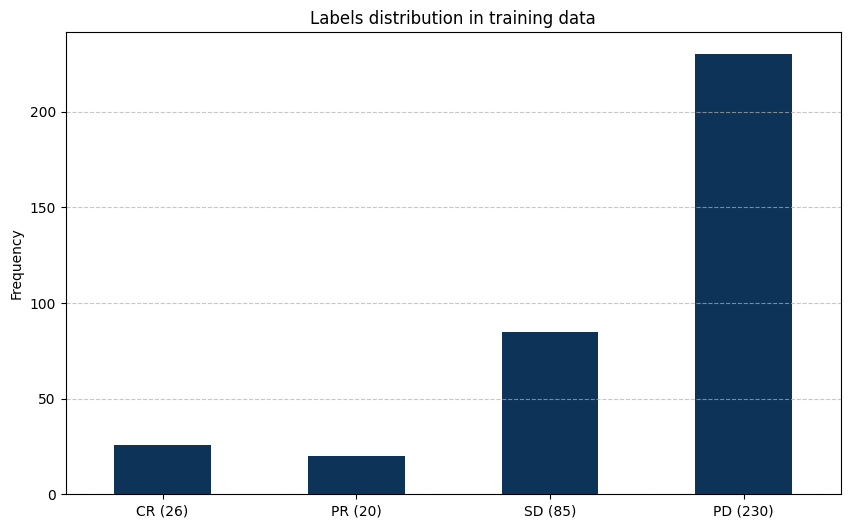

In [10]:
freqs = get_distribution(patient_json=patients_dict)
categories = [f"CR ({freqs[0]})", f"PR ({freqs[1]})", f"SD ({freqs[2]})", f"PD ({freqs[3]})"]

plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=freqs, color="#003366", width=0.5)
plt.title("Labels distribution in training data")
# plt.grid(True);
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylabel("Frequency")
plt.show();

In [11]:
kfold_path = data_path / "split.json"

with open(kfold_path, "r") as f:
    kfold = json.load(f)

In [12]:
folds = [
    get_dataset(data_path=data_path, patients_ids=patients_ids)[0]
    for _, patients_ids in kfold.items()
]

cases_per_fold = [len(fold) for fold in folds]
patients_per_fold = [len(patients_ids) for _, patients_ids in kfold.items()]
freqs_per_fold = [get_distribution(patient_json=patients_dict, patients_ids=patients_ids) for _, patients_ids in kfold.items()]

In [13]:
freqs_per_fold = np.array(freqs_per_fold)
num_folds = freqs_per_fold.shape[0]
num_classes = freqs_per_fold.shape[1]

class_freqs = freqs_per_fold.T
x = np.arange(num_classes)
bar_width = 0.15
offsets = np.linspace(-2, 2, num_folds) * bar_width

colors = [
    "#007A95",
    "#00B5B3",
    "#70C1B3",
    "#F7C6C7",
    "#F7E199"
]

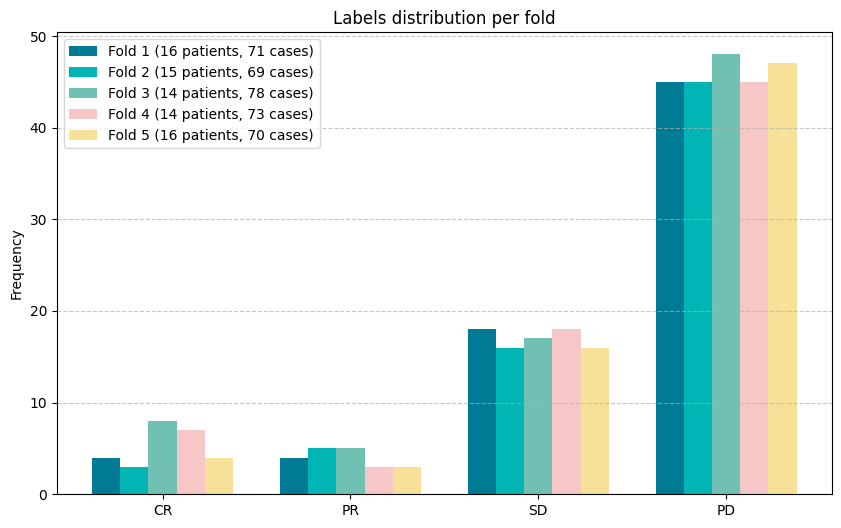

In [14]:
plt.figure(figsize=(10, 6))

for fold_idx in range(num_folds):
    plt.bar(x + offsets[fold_idx], class_freqs[:, fold_idx],
            width=bar_width, label=f"Fold {fold_idx + 1} ({patients_per_fold[fold_idx]} patients, {cases_per_fold[fold_idx]} cases)",
            color=colors[fold_idx % len(colors)])

plt.ylabel("Frequency")
plt.title("Labels distribution per fold")
plt.xticks(x, ["CR", "PR", "SD", "PD"])
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.grid(True)
plt.show();